In [185]:
# Load Transaction Data from a CSV File

### DISCLAIMER: 
### FOR ALL TAX-RELATED QUESTIONS AND CONCERNS PLEASE ASK A CERTIFIED ACCOUNTANT

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# What Year are we generating for
TAX_YEAR = 2018
# Set this to the Mortgage Interest Paid for the year
MORTGAGE_INTEREST = float(3313.01)
EST_DEPRECIATION = float(5363)
EST_AMMORTIZATION = float(75)

# Name of the CSV file that has all of the property related transaction data from Min
# / the directory where you are running jupyter notebook
PATH_TO_YOUR_TRANSACTIONS = "transactions.csv"

# Name of the output CSV file that we'll create
OUTPUT_CSV = str(TAX_YEAR) + ' Schedule E Income and Loss.csv'

# Set the name of the column where the transactions are categorized
# In Mint this is usually "Category".  I use Mint's category to link 
# transactions to a property and the add a seperate "Label" column
# after exporting the data for a property from Min
CATEGORY = "Label"

# Load the transaction data from the csv into a dataframe
parse_dates = ['Date']
df = pd.read_csv(PATH_TO_YOUR_TRANSACTIONS, parse_dates=parse_dates)
df.set_index(['Date'], inplace=True)
df['Amount'] = df['Amount'].astype(float)

# Get rid of Mint columns that we don't care about
df.drop(['Original Description','Actual Amount','Notes'], axis=1, inplace=True)
df.sort_index(inplace=True)
# df.head()

In [186]:
# Exclude the data for everything except our tax year
df = df[df.index.year == TAX_YEAR]
# df.head()

In [187]:
# Find all the categories that have both credits and debits and adjust the overall expense
two_cats_df = df
for label in df[CATEGORY].unique():
    if df[df[CATEGORY] == label]['Transaction Type'].nunique() <= 1:
        two_cats_df = two_cats_df[two_cats_df[CATEGORY] != label]

# Convert the credits to negative debits so that these will be viewed as expenses
def find_refunds(row):
    """ Look for transactions that have a
        credit for a typical "spending" label
        Change these to a debit with a negative
        amount.

        This results in the refunds getting subtracted
        from the total spend calculations
    """
    if row['Transaction Type'] == 'credit':
        print (row[CATEGORY]+' -- Credit on ' + row.name.strftime('%m/%d/%Y') + ' from '+ \
               row.Description + ' for ${:,.2f}'.format(row.Amount))
        row.Amount *= -1
        row['Transaction Type'] = 'debit'
    return row

print('Below are the transactions that were "credits" in categories that we consider expenses:\n')

for label in two_cats_df[CATEGORY].unique():
    df[df[CATEGORY] == label] = df[df[CATEGORY] == label].apply(find_refunds, axis=1)

print('\nThe overall expense totals in these categories have been adjusted with these credits.')


Below are the transactions that were "credits" in categories that we consider expenses:

Supplies -- Credit on 06/07/2018 from Home Depot - Different bits for $17.25
Supplies -- Credit on 10/13/2018 from Home Depot -repair parts for vacant apts for $56.13
Supplies -- Credit on 10/28/2018 from Home Depot - Returned shelf parts for $27.74
Mortgage -- Credit on 01/05/2018 from City Tax Payment from Escrow for $2,337.97
Mortgage -- Credit on 03/12/2018 from 122 Spring Street Escrow Refund for $1,411.91
Utilities -- Credit on 01/06/2018 from 122 Spring Street Upstairs Dec Nat Grid overage for $60.00
Utilities -- Credit on 02/06/2018 from 122 Spring Street Upstairs Feb Nat Grid for $80.00
Utilities -- Credit on 02/07/2018 from 122 Spring Apt 1W Feb Nat Grid for $24.00
Utilities -- Credit on 02/16/2018 from 122 Spring Apt 1E NatGrid via Google Wallet for $24.00
Utilities -- Credit on 03/07/2018 from 122 Spring Street Upstairs May Utilities for $50.00
Utilities -- Credit on 04/04/2018 from 122

In [188]:
# Get the expense and income data that we'll report on our Schedule E

# If any exist, we exclude closing costs from the year over year expense visualization
df = df[df[CATEGORY] != 'Closing']
# We exclude secuirty deposits from the income/expense reporting
df = df[df[CATEGORY] != 'Security']

# We also remove mortgage payments for tax expense calculation
# We may deduct only the interest payments which we need to get from the lender
df = df[df[CATEGORY] != 'Mortgage']


expenses_df = df[df['Transaction Type'] == 'debit'].copy()
income_df = df[df['Transaction Type'] == 'credit'].copy()

# Re-assign some CATEGORIES to the ones that are on the Tax form 
expenses_df.loc[:][expenses_df[CATEGORY] == 'Water'] = 'Utilities'
expenses_df.loc[:][expenses_df[CATEGORY] == 'Garbage'] = 'Utilities'
expenses_df.loc[:][expenses_df[CATEGORY] == 'Phone'] = 'Supplies'

# We treat any Pet Deposits as Income so we'll just call it "Rent"
income_df.loc[:][income_df[CATEGORY] == 'Pet Deposit'] = 'Rent'


                          Amount
Label                           
Maintenance               290.00
Mortgage Interest        3313.01
Repairs                  5917.34
Supplies                 1703.69
Taxes                    5360.01
Utilities                3973.57
Estimated Depreciation   5363.00
Estimated Ammortization    75.00
Amount    25995.62
dtype: float64


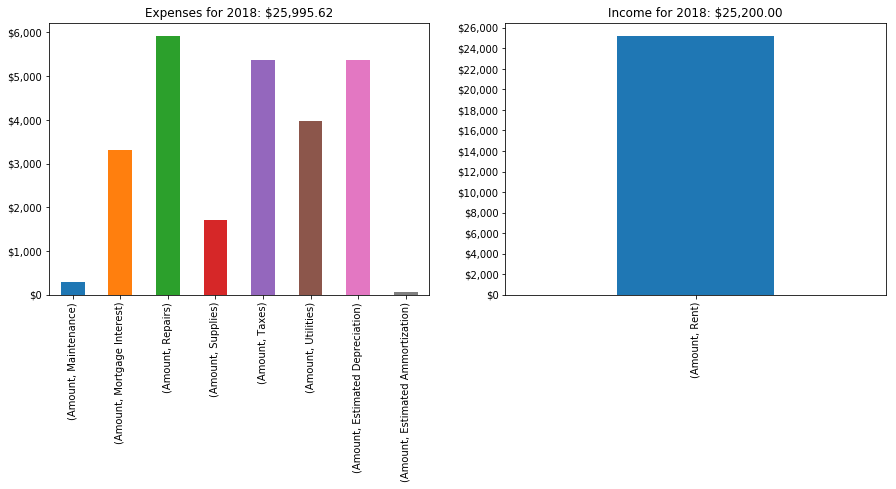

In [189]:
# Visualize Year over Year Expenses and Income by Category
# Group the expenses and income by category and year
#g = expenses_df.groupby([CATEGORY, expenses_df.index.year])
g = expenses_df.groupby([CATEGORY])
expenses = g.sum()

if MORTGAGE_INTEREST:
    expenses.loc['Mortgage Interest'] = [MORTGAGE_INTEREST]

expenses.sort_index(inplace=True)

if EST_DEPRECIATION:
    expenses.loc['Estimated Depreciation'] = [EST_DEPRECIATION]
    
if EST_AMMORTIZATION:
    expenses.loc['Estimated Ammortization'] = [EST_AMMORTIZATION]

#g = income_df.groupby([CATEGORY, income_df.index.year])
g = income_df.groupby([CATEGORY])
income = g.sum()

# If any "expenses" were actually income in a given year add them to income
# For example, this could happen when we took in more security than we paid out
expense_as_income = expenses[expenses['Amount'] < 0]
if not expense_as_income.empty:
    expenses = expenses[expenses['Amount'] >= 0]
    expense_as_income = expense_as_income.abs()
    income = income.append(expense_as_income)

# Calculate and store the expense/income for each year
e_totals = expenses.sum()
print(e_totals)
i_totals = income.sum()

# Visualize by category per year, legend will have annual totals
# We will have to plots side by side
ax1 = plt.subplot(1,2,1)
title='Expenses for '+str(TAX_YEAR)+': ${:,.2f}'.format(e_totals.Amount)
expenses.unstack(-1).plot.bar(title=title, figsize=[20,20], width=0.5, ax=ax1)
ax2 = plt.subplot(1,2,2)
title='Income for '+str(TAX_YEAR)+': ${:,.2f}'.format(i_totals.Amount)
income.unstack(-1).plot.bar(title=title, figsize=[15,5], width=0.35, ax=ax2)


# Format the yticks as currency, and remove the x-labels
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax2.yaxis.set_major_formatter(tick) 
tick_spacing = 1000
ax1.yaxis.set_major_locator(mtick.MultipleLocator(tick_spacing))
ax1.set_xlabel('')
tick_spacing = 2000
ax2.yaxis.set_major_locator(mtick.MultipleLocator(tick_spacing))
ax2.set_xlabel('')

# Semicolot after plot hides a bunch of garbage showing in jupyter
plt.show();

In [190]:
# Output the Tax Related Income and Expense Data to a CSV

# Rename our columns to the terms used on IRS Schedule E
income.rename(index={'Rent':'Rents received'},  inplace=True)
income = income.append(expenses)
mortgage = pd
income
income.to_csv(OUTPUT_CSV, float_format="%.2f")

,Amount
Label,
Rents received,25200.00
Maintenance,290.00
Mortgage Interest,3313.01
Repairs,5917.34
Supplies,1703.69
Taxes,5360.01
Utilities,3973.57
Estimated Depreciation,5363.00
Estimated Ammortization,75.00
